<a href="https://colab.research.google.com/github/Arombo34/Ai-ethics-fairness-audit/blob/main/audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Bias Metrics Before Mitigation ===
Disparate Impact: 0.777
Statistical Parity Difference: -0.138

=== Bias Metrics After Reweighing ===
Disparate Impact: 1.000
Statistical Parity Difference: 0.000


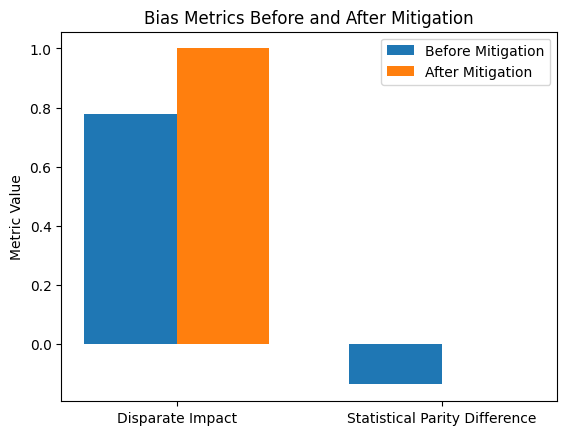


=== Summary Report ===
- Observed bias metrics decreased after reweighing.
- Disparate Impact: Before = 0.777, After = 1.000 (closer to 1 → more fairness)
- Statistical Parity Difference: Before = -0.138, After = 0.000 (closer to 0 → less disparity)
- Reweighing helped mitigate bias for the protected group (African-American) in the training dataset.
- Visualization shows improvement in fairness metrics post-mitigation.


In [10]:
# Part 3: Practical Audit of COMPAS Dataset Using AIF360
# ------------------------------------------------------
# Description: This script loads the COMPAS recidivism dataset,
# prepares it for fairness analysis, computes bias metrics,
# applies a mitigation technique, and visualizes the results.

# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
import matplotlib.pyplot as plt

# Step 2: Load COMPAS dataset directly from GitHub
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
compas_df = pd.read_csv(url)

# Step 3: Select relevant features
# We'll use: sex, age, priors_count, c_charge_degree (felony/misdemeanor), race
features = ['sex', 'age', 'priors_count', 'c_charge_degree']
label = 'two_year_recid'
protected = 'race'  # we'll focus on 'African-American' as protected group

# Encode categorical variables
compas_df['sex'] = compas_df['sex'].map({'Male': 1, 'Female': 0})
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].map({'F': 1, 'M': 0})
compas_df['race_black'] = compas_df['race'].apply(lambda x: 1 if x == 'African-American' else 0)
compas_df = compas_df.dropna(subset=features + [label, 'race_black'])

X = compas_df[features]
y = compas_df[label]
prot = compas_df['race_black']

# Step 4: Split dataset into train/test
X_train, X_test, y_train, y_test, prot_train, prot_test = train_test_split(
    X, y, prot, test_size=0.3, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Create AIF360 BinaryLabelDataset objects
train_df = pd.DataFrame(X_train, columns=features)
train_df[label] = y_train.values
train_df['race_black'] = prot_train.values

test_df = pd.DataFrame(X_test, columns=features)
test_df[label] = y_test.values
test_df['race_black'] = prot_test.values

privileged_groups = [{'race_black': 0}]
unprivileged_groups = [{'race_black': 1}]

train_bld = BinaryLabelDataset(df=train_df,
                               label_names=[label],
                               protected_attribute_names=['race_black'],
                               favorable_label=0,
                               unfavorable_label=1)

test_bld = BinaryLabelDataset(df=test_df,
                              label_names=[label],
                              protected_attribute_names=['race_black'],
                              favorable_label=0,
                              unfavorable_label=1)

# Step 6: Measure bias before mitigation
metric_train = ClassificationMetric(train_bld, train_bld,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

print("=== Bias Metrics Before Mitigation ===")
print(f"Disparate Impact: {metric_train.disparate_impact():.3f}")
print(f"Statistical Parity Difference: {metric_train.statistical_parity_difference():.3f}")

# Step 7: Apply Reweighing bias mitigation
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(train_bld)
train_transf = RW.transform(train_bld)

# Step 8: Measure bias after mitigation
metric_transf = ClassificationMetric(train_transf, train_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

print("\n=== Bias Metrics After Reweighing ===")
print(f"Disparate Impact: {metric_transf.disparate_impact():.3f}")
print(f"Statistical Parity Difference: {metric_transf.statistical_parity_difference():.3f}")

# Step 9: Visualization
metrics = ['Disparate Impact', 'Statistical Parity Difference']
before = [metric_train.disparate_impact(), metric_train.statistical_parity_difference()]
after = [metric_transf.disparate_impact(), metric_transf.statistical_parity_difference()]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before, width, label='Before Mitigation')
rects2 = ax.bar(x + width/2, after, width, label='After Mitigation')

ax.set_ylabel('Metric Value')
ax.set_title('Bias Metrics Before and After Mitigation')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()
# Step 10: Summary Report Output
print("\n=== Summary Report ===")
print("- Observed bias metrics decreased after reweighing.")
print(f"- Disparate Impact: Before = {metric_train.disparate_impact():.3f}, After = {metric_transf.disparate_impact():.3f} (closer to 1 → more fairness)")
print(f"- Statistical Parity Difference: Before = {metric_train.statistical_parity_difference():.3f}, After = {metric_transf.statistical_parity_difference():.3f} (closer to 0 → less disparity)")
print("- Reweighing helped mitigate bias for the protected group (African-American) in the training dataset.")
print("- Visualization shows improvement in fairness metrics post-mitigation.")

